In [1]:
import os
import re
import sqlite3
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from IPython.display import display

In [2]:
columns = [
  'Player',
  'Tm',
  'Age',
  'Pos',
  'G',
  'GS',
  'QBrec',
  'Cmp',
  'Att',
  'Cmp%',
  'Yds',
  'TD',
  'TD%',
  'Int',
  'Int%',
  '1D',
  'Lng',
  'Y/A',
  'AY/A',
  'Y/C',
  'Y/G',
  'Rate',
  'QBR',
  'Sk',
  'Yds2',
  'Sk%',
  'NY/A',
  'ANY/A',
  '4QC',
  'GWD',
]

In [3]:
def parse(html, season):
    data = []

    bs = BeautifulSoup(html)
    for row in bs.select('#div_passing tbody tr'):
        tds = row.select('td')

        if len(tds) != len(columns):
            continue

        data.append(
            [td.text for td in tds] + [season]
        )

    return data

In [4]:
data = []
for season in (str(year) for year in range(2017, 2023)):
    response = requests.get(f'https://www.pro-football-reference.com/years/{season}/passing.htm')
    assert response.status_code == 200
    
    observations = parse(response.text, season)
    data.extend(observations)

In [5]:
df = pd.DataFrame(data, columns=columns + ['season'])
df.head()

,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,Cmp%,...,Rate,QBR,Sk,Yds2,Sk%,NY/A,ANY/A,4QC,GWD,season
0,Tom Brady*+,NWE,40,QB,16,16,13-3-0,385,581,66.3,...,102.8,70.6,35,201,5.7,7.10,7.56,2,2,2017
1,Philip Rivers*,LAC,36,QB,16,16,9-7-0,360,575,62.6,...,96.0,61.1,18,120,3,7.41,7.60,2,2,2017
2,Matthew Stafford,DET,29,QB,16,16,9-7-0,371,565,65.7,...,99.3,65.2,47,287,7.7,6.80,7.01,1,4,2017
3,Drew Brees*,NOR,38,QB,16,16,11-5-0,386,536,72,...,103.9,62.5,20,145,3.6,7.53,7.71,2,2,2017
4,Ben Roethlisberger*,PIT,35,QB,15,15,12-3-0,360,561,64.2,...,93.4,66.6,21,139,3.6,7.07,6.95,3,4,2017


In [6]:
def clean_name(text):
    text = re.sub(r'[+* ]+$', '', text)
    text = text.strip()
    return text
    
df['Player'] = df['Player'].map(clean_name)

In [7]:
df.to_csv('../../data/nfl/quarterbacks.csv', index=False)

In [8]:
def build_bulk_insert_sql(df, table_name):
    sql = f"""INSERT INTO {table_name} ({', '.join(df.columns)}) VALUES"""

    dtypes = list(df.dtypes.to_dict().items())
    df = df.fillna(np.nan).replace([np.nan], [None])

    for _, row in df.iterrows():
        insertable = []
        for col, dtype in dtypes:
            value = row[col]
            if dtype.name == 'object' and not value is None:
                insertable.append('"' + str(row[col]).strip() + '"')
            elif value is None:
                insertable.append('NULL')
            else:
                insertable.append(str(row[col]))

        insertable_sql = ', '.join(insertable)
        sql += f'\n({insertable_sql}),'

    return sql[:-1]

In [9]:
quarterbacks = df[['Player', 'Cmp', 'Att', 'Yds', 'Int', 'TD', 'season']].copy()
quarterbacks.columns = ['name', 'completions', 'attempts', 'yards', 'interceptions', 'touchdowns', 'season']

quarterbacks['completions'] = quarterbacks['completions'].astype(int)
quarterbacks['attempts'] = quarterbacks['attempts'].astype(int)
quarterbacks['yards'] = quarterbacks['yards'].astype(int)
quarterbacks['interceptions'] = quarterbacks['interceptions'].astype(int)
quarterbacks['touchdowns'] = quarterbacks['touchdowns'].astype(int)

quarterbacks.head()

,name,completions,attempts,yards,interceptions,touchdowns,season
0,Tom Brady,385,581,4577,8,32,2017
1,Philip Rivers,360,575,4515,10,28,2017
2,Matthew Stafford,371,565,4446,10,29,2017
3,Drew Brees,386,536,4334,8,23,2017
4,Ben Roethlisberger,360,561,4251,14,28,2017


In [10]:
quarterbacks.dtypes

name             object
completions       int64
attempts          int64
yards             int64
interceptions     int64
touchdowns        int64
season           object
dtype: object

In [11]:
insert_sql = build_bulk_insert_sql(quarterbacks, 'quarterbacks')

In [12]:
create_table_sql = """
  CREATE TABLE quarterbacks(
    name VARCHAR(200) NOT NULL,
    season VARCHAR(50) NOT NULL,
    completions NUMERIC NOT NULL,
    attempts NUMERIC NOT NULL,
    yards NUMERIC NOT NULL,
    interceptions NUMERIC NOT NULL,
    touchdowns NUMERIC NOT NULL,

    PRIMARY KEY (name, season)
  );
"""

In [13]:
if os.path.exists('../../data/nfl/quarterbacks.sqlite3'):
    os.remove('../../data/nfl/quarterbacks.sqlite3')

with sqlite3.connect('../../data/nfl/quarterbacks.sqlite3') as conn:
    cur = conn.cursor()
    cur.execute(create_table_sql)
    cur.execute(insert_sql)

In [14]:
with sqlite3.connect('../../data/nfl/quarterbacks.sqlite3') as conn:
    cur = conn.cursor()
    cur.execute('select * from quarterbacks;')

    records = cur.fetchall()

    for row in records[:5]:
        print(row)

    for row in records[-5:]:
        print(row)

('Tom Brady', '2017', 385, 581, 4577, 8, 32)
('Philip Rivers', '2017', 360, 575, 4515, 10, 28)
('Matthew Stafford', '2017', 371, 565, 4446, 10, 29)
('Drew Brees', '2017', 386, 536, 4334, 8, 23)
('Ben Roethlisberger', '2017', 360, 561, 4251, 14, 28)
('DeeJay Dallas', '2022', 0, 1, 0, 1, 0)
('Chad Henne', '2022', 0, 2, 0, 0, 0)
('Christian Kirk', '2022', 0, 1, 0, 0, 0)
('Cooper Kupp', '2022', 0, 1, 0, 0, 0)
('Tommy Townsend', '2022', 0, 1, 0, 0, 0)


### Viz

In [15]:
def show(df, attribute):
    x = df[attribute]
    mu = x.mean()
    
    plt.hist(x, bins = 18)
    plt.axvline(x=mu, color='r', label='mu')
    plt.legend()
    plt.show()

    print('mu:', mu)
    display(df.sort_values([attribute], ascending=False))

In [16]:
min_attempts = 120

quarterbacks['ypa'] = quarterbacks.yards / quarterbacks.attempts
quarterbacks['ipa'] = quarterbacks.interceptions / quarterbacks.attempts
quarterbacks['tpa'] = quarterbacks.touchdowns / quarterbacks.attempts

subset_quarterbacks = quarterbacks.loc[quarterbacks.attempts >= min_attempts].copy()

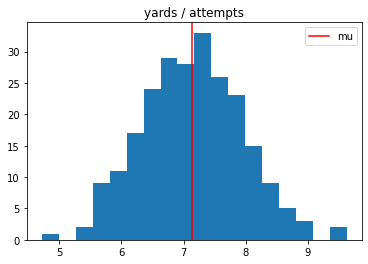

mu: 7.143882682199869


,name,completions,attempts,yards,interceptions,touchdowns,season,ypa,ipa,tpa
121,Ryan Fitzpatrick,164,246,2366,12,17,2018,9.617886,0.048780,0.069106
227,Ryan Tannehill,201,286,2742,6,22,2019,9.587413,0.020979,0.076923
546,Tua Tagovailoa,130,186,1678,3,12,2022,9.021505,0.016129,0.064516
419,Joe Burrow,366,520,4611,14,34,2021,8.867308,0.026923,0.065385
302,Deshaun Watson,382,544,4823,7,33,2020,8.865809,0.012868,0.060662
...,...,...,...,...,...,...,...,...,...,...
238,David Blough,94,174,984,6,4,2019,5.655172,0.034483,0.022989
39,Drew Stanton,79,159,894,5,6,2017,5.622642,0.031447,0.037736
457,Cam Newton,69,126,684,5,4,2021,5.428571,0.039683,0.031746
133,Cody Kessler,85,131,709,2,2,2018,5.412214,0.015267,0.015267


In [17]:
### yards / attempts
plt.title('yards / attempts')

show(
    subset_quarterbacks,
    'ypa'
)

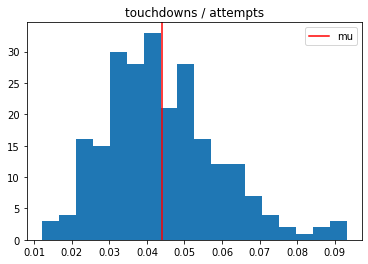

mu: 0.044151173092643


,name,completions,attempts,yards,interceptions,touchdowns,season,ypa,ipa,tpa
30,Deshaun Watson,126,204,1699,8,19,2017,8.328431,0.039216,0.093137
308,Aaron Rodgers,372,526,4299,5,48,2020,8.173004,0.009506,0.091255
221,Lamar Jackson,265,401,3127,6,36,2019,7.798005,0.014963,0.089776
447,Jameis Winston,95,161,1170,3,14,2021,7.267081,0.018634,0.086957
95,Patrick Mahomes,383,580,5097,12,50,2018,8.787931,0.020690,0.086207
...,...,...,...,...,...,...,...,...,...,...
35,Brian Hoyer,123,211,1287,4,4,2017,6.099526,0.018957,0.018957
33,C.J. Beathard,123,224,1430,6,4,2017,6.383929,0.026786,0.017857
449,Tyler Huntley,122,188,1081,4,3,2021,5.750000,0.021277,0.015957
133,Cody Kessler,85,131,709,2,2,2018,5.412214,0.015267,0.015267


In [18]:
plt.title('touchdowns / attempts')

show(
    subset_quarterbacks,
    'tpa'
)

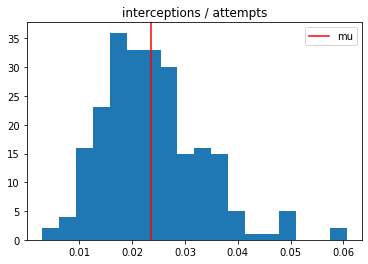

mu: 0.023649026905287463


,name,completions,attempts,yards,interceptions,touchdowns,season,ypa,ipa,tpa
452,Mike White,88,132,953,8,5,2021,7.219697,0.060606,0.037879
453,Mike Glennon,90,167,790,10,4,2021,4.730539,0.059880,0.023952
558,Mac Jones,91,138,993,7,3,2022,7.195652,0.050725,0.021739
235,Devlin Hodges,100,160,1063,8,5,2019,6.643750,0.050000,0.031250
121,Ryan Fitzpatrick,164,246,2366,12,17,2018,9.617886,0.048780,0.069106
...,...,...,...,...,...,...,...,...,...,...
533,Jalen Hurts,163,239,2042,2,12,2022,8.543933,0.008368,0.050209
423,Aaron Rodgers,366,531,4115,4,37,2021,7.749529,0.007533,0.069680
210,Aaron Rodgers,353,569,4002,4,26,2019,7.033392,0.007030,0.045694
99,Aaron Rodgers,372,597,4442,2,25,2018,7.440536,0.003350,0.041876


In [19]:
### interceptions / attempts
plt.title('interceptions / attempts')

show(
    subset_quarterbacks,
    'ipa'
)

In [20]:
### ypa / tpa ~ "somewhat" correlated
print(quarterbacks[['ypa', 'ipa', 'tpa']].corr())

          ypa       ipa       tpa
ypa  1.000000 -0.172745  0.513335
ipa -0.172745  1.000000 -0.076958
tpa  0.513335 -0.076958  1.000000
